In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
BATCH_SIZE = 64
LR_pretrain = 0.001
LR_adapt = 0.0001  # Lower for adversarial stability
N_EPOCHS_PRETRAIN = 30
N_EPOCHS_ADAPT = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running ADDA on {DEVICE}")

Running ADDA on cuda


In [46]:
#Loading data
X_pdb = np.load('/content/drive/MyDrive/features/pdb_maps.npy')
X_af = np.load('/content/drive/MyDrive/features/af_maps.npy')
y = np.load('/content/drive/MyDrive/features/labels.npy')

#spliting the dataset (same as naive and DANN)
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)

X_train_pdb = X_pdb[train_idx]
X_train_af = X_af[train_idx]
y_train = y[train_idx]

X_test_pdb = X_pdb[test_idx]
X_test_af = X_af[test_idx]
y_test = y[test_idx]

print(f"Train: {len(X_train_pdb)} | Test: {len(X_test_af)}")

#class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

Train: 9641 | Test: 2411


In [47]:
#data loaders
source_ds = TensorDataset(
    torch.tensor(X_train_pdb, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_train, dtype=torch.long)
)
source_loader = DataLoader(source_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

target_ds = TensorDataset(
    torch.tensor(X_train_af, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_train, dtype=torch.long)  # Not used during adaptation
)
target_loader = DataLoader(target_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_pdb_ds = TensorDataset(
    torch.tensor(X_test_pdb, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_test, dtype=torch.long)
)
test_af_ds = TensorDataset(
    torch.tensor(X_test_af, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_test, dtype=torch.long)
)
test_pdb_loader = DataLoader(test_pdb_ds, batch_size=BATCH_SIZE)
test_af_loader = DataLoader(test_af_ds, batch_size=BATCH_SIZE)


In [48]:
#Models
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        return x.view(x.size(0), -1)

class Classifier(nn.Module):
    def __init__(self, input_dim=256, num_classes=7):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [49]:
# Phase 1: Pretraining on Source (PDB)
source_encoder = FeatureExtractor().to(DEVICE)
classifier = Classifier(256, 7).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_pretrain = optim.Adam(
    list(source_encoder.parameters()) + list(classifier.parameters()),
    lr=LR_pretrain
)
scheduler = optim.lr_scheduler.StepLR(optimizer_pretrain, step_size=15, gamma=0.5)

def evaluate_encoder(encoder, classifier, loader):
    encoder.eval()
    classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            features = encoder(X)
            preds = classifier(features).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

for epoch in range(N_EPOCHS_PRETRAIN):
    source_encoder.train()
    classifier.train()
    total_loss = 0

    for X, y in source_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        features = source_encoder(X)
        output = classifier(features)
        loss = criterion(output, y)

        optimizer_pretrain.zero_grad()
        loss.backward()
        optimizer_pretrain.step()

        total_loss += loss.item()

    scheduler.step()

    if (epoch + 1) % 10 == 0:
        pdb_acc = evaluate_encoder(source_encoder, classifier, test_pdb_loader)
        af_acc = evaluate_encoder(source_encoder, classifier, test_af_loader)
        print(f"Epoch {epoch+1}/{N_EPOCHS_PRETRAIN} | Loss: {total_loss/len(source_loader):.4f} | PDB: {pdb_acc:.2f}% | AF: {af_acc:.2f}%")

print("\nPretrain complete.")
pdb_acc = evaluate_encoder(source_encoder, classifier, test_pdb_loader)
af_acc = evaluate_encoder(source_encoder, classifier, test_af_loader)
print(f"Source (PDB) Acc: {pdb_acc:.2f}%")
print(f"Target (AF) Acc (before adaptation): {af_acc:.2f}%")

# Phase 2: Adversarial Adaptation

#initialize target encoder with source encoder weights
target_encoder = FeatureExtractor().to(DEVICE)
target_encoder.load_state_dict(source_encoder.state_dict())

#freeze source encoder
for param in source_encoder.parameters():
    param.requires_grad = False

#discriminator
discriminator = Discriminator(256).to(DEVICE)

#optimizers
optimizer_tgt = optim.Adam(target_encoder.parameters(), lr=LR_adapt, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=LR_adapt, betas=(0.5, 0.999))

#loss
bce_loss = nn.BCEWithLogitsLoss()

#track best
best_af_acc = 0
best_epoch = 0

for epoch in range(N_EPOCHS_ADAPT):
    target_encoder.train()
    discriminator.train()
    source_encoder.eval()

    total_disc_loss = 0
    total_tgt_loss = 0

    target_iter = iter(target_loader)

    for source_x, _ in source_loader:
        try:
            target_x, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            target_x, _ = next(target_iter)

        source_x = source_x.to(DEVICE)
        target_x = target_x.to(DEVICE)

        #labels: source=1, target=0
        source_labels = torch.ones(source_x.size(0), 1).to(DEVICE)
        target_labels = torch.zeros(target_x.size(0), 1).to(DEVICE)

        # ---- Train Discriminator ----
        optimizer_disc.zero_grad()

        with torch.no_grad():
            source_features = source_encoder(source_x)
        target_features = target_encoder(target_x)

        source_pred = discriminator(source_features.detach())
        target_pred = discriminator(target_features.detach())

        disc_loss = bce_loss(source_pred, source_labels) + bce_loss(target_pred, target_labels)
        disc_loss.backward()
        optimizer_disc.step()

        total_disc_loss += disc_loss.item()

        # ---- Train Target Encoder (fool discriminator) ----
        optimizer_tgt.zero_grad()

        target_features = target_encoder(target_x)
        target_pred = discriminator(target_features)

        #target encoder wants discriminator to think target is source (label=1)
        tgt_loss = bce_loss(target_pred, source_labels)
        tgt_loss.backward()

        torch.nn.utils.clip_grad_norm_(target_encoder.parameters(), max_norm=1.0)
        optimizer_tgt.step()

        total_tgt_loss += tgt_loss.item()

    #evaluate
    af_acc = evaluate_encoder(target_encoder, classifier, test_af_loader)

    #save best
    if af_acc > best_af_acc:
        best_af_acc = af_acc
        best_epoch = epoch + 1
        torch.save({
            'target_encoder': target_encoder.state_dict(),
            'classifier': classifier.state_dict(),
        }, 'adda_best.pth')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{N_EPOCHS_ADAPT} | D Loss: {total_disc_loss/len(source_loader):.4f} | T Loss: {total_tgt_loss/len(source_loader):.4f} | AF: {af_acc:.2f}%")


Epoch 10/30 | Loss: 0.3363 | PDB: 60.02% | AF: 58.32%
Epoch 20/30 | Loss: 0.0748 | PDB: 74.37% | AF: 74.04%
Epoch 30/30 | Loss: 0.0351 | PDB: 74.70% | AF: 73.75%

Pretrain complete.
Source (PDB) Acc: 74.70%
Target (AF) Acc (before adaptation): 73.75%
Epoch 5/50 | D Loss: 1.3893 | T Loss: 0.6873 | AF: 67.81%
Epoch 10/50 | D Loss: 1.3899 | T Loss: 0.6862 | AF: 81.05%
Epoch 15/50 | D Loss: 1.3891 | T Loss: 0.6874 | AF: 77.69%
Epoch 20/50 | D Loss: 1.3880 | T Loss: 0.6898 | AF: 82.95%
Epoch 25/50 | D Loss: 1.3880 | T Loss: 0.6911 | AF: 83.45%
Epoch 30/50 | D Loss: 1.3877 | T Loss: 0.6921 | AF: 85.73%
Epoch 35/50 | D Loss: 1.3871 | T Loss: 0.6927 | AF: 86.27%
Epoch 40/50 | D Loss: 1.3872 | T Loss: 0.6927 | AF: 85.48%
Epoch 45/50 | D Loss: 1.3869 | T Loss: 0.6925 | AF: 88.05%
Epoch 50/50 | D Loss: 1.3869 | T Loss: 0.6933 | AF: 85.69%


In [50]:
#load best and final result
checkpoint = torch.load('adda_best.pth')
target_encoder.load_state_dict(checkpoint['target_encoder'])
classifier.load_state_dict(checkpoint['classifier'])

print(f"\n=== ADDA Final Results (Best @ Epoch {best_epoch}) ===")
pdb_acc = evaluate_encoder(source_encoder, classifier, test_pdb_loader)
af_acc = evaluate_encoder(target_encoder, classifier, test_af_loader)

print(f"Accuracy on PDB (source encoder): {pdb_acc:.2f}%")
print(f"Accuracy on AlphaFold (target encoder): {af_acc:.2f}%")




=== ADDA Final Results (Best @ Epoch 45) ===
Accuracy on PDB (source encoder): 74.70%
Accuracy on AlphaFold (target encoder): 88.05%


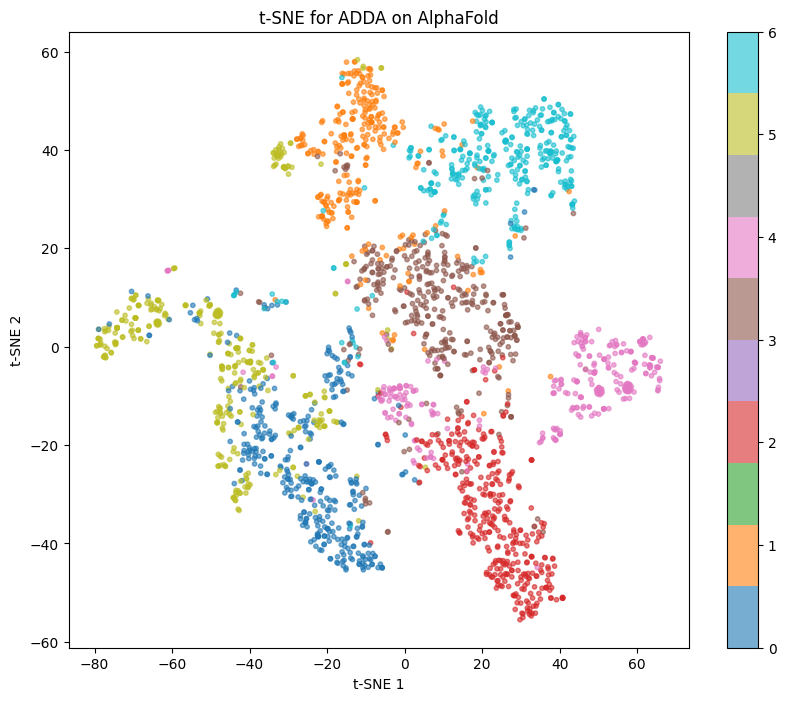

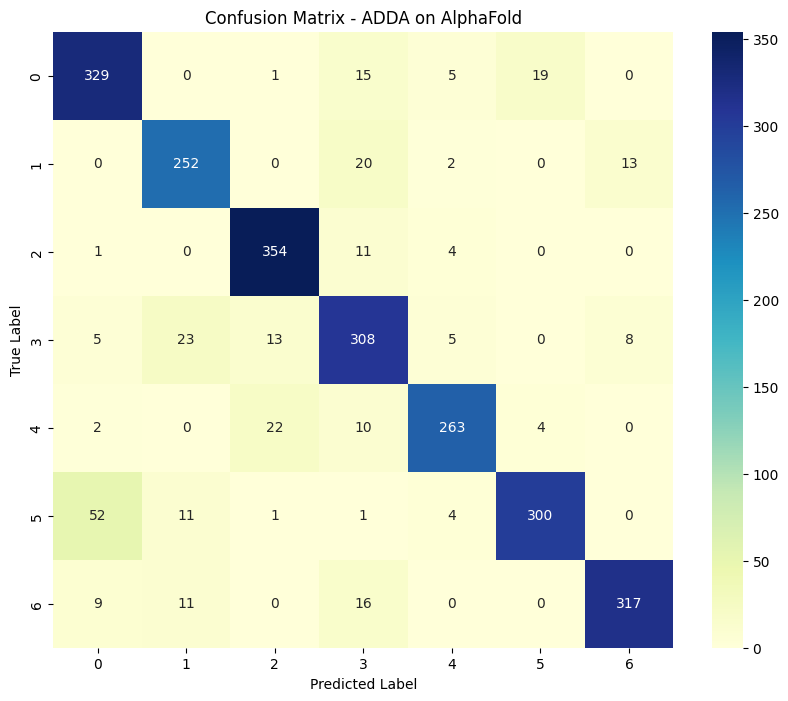


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       369
           1       0.85      0.88      0.86       287
           2       0.91      0.96      0.93       370
           3       0.81      0.85      0.83       362
           4       0.93      0.87      0.90       301
           5       0.93      0.81      0.87       369
           6       0.94      0.90      0.92       353

    accuracy                           0.88      2411
   macro avg       0.88      0.88      0.88      2411
weighted avg       0.88      0.88      0.88      2411



In [51]:
#Visualisation
target_encoder.eval()
classifier.eval()
features = []
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y_batch in test_af_loader:
        X = X.to(DEVICE)
        feat = target_encoder(X)
        preds = classifier(feat).argmax(dim=1)

        features.append(feat.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.numpy())

features = np.concatenate(features)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter)
plt.title('t-SNE for ADDA on AlphaFold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('adda_tsne.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - ADDA on AlphaFold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('adda_confusion.png')
plt.show()

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds))